<a href="https://colab.research.google.com/github/abhiraman/Capstone_Project/blob/main/Image_to_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Dependencies

In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
import cv2
import os
import matplotlib.pyplot as plt
import random
import numpy as np
from matplotlib import font_manager
import time
from  torch.utils.data import Dataset,DataLoader 
import pandas as pd
from torchvision import transforms
from skimage import io
from tqdm import tqdm
from collections import OrderedDict

Mounting Drive

In [79]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [80]:
%cd /gdrive/MyDrive/Capstone_project_data/ImgtoText/Cropped_Images/cropped_data

/gdrive/MyDrive/Capstone_project_data/ImgtoText/Cropped_Images/cropped_data


In [81]:
!ls

annotations.txt  cropped_dir  model_Text_Recognition.pt  readme.txt


In [82]:
#!unzip TrainImages.zip

In [83]:
if torch.cuda.is_available():
  MyDevice = torch.device("cuda")
else:
  MyDevice = torch.device("cpu")

print(MyDevice)

cuda


# Data Loader 

In [84]:
## All Hindi Alphabets ## 
all_hindi_alpha = [" "]+[chr(i) for i in range(2304,2432)]
all_hindi_alpha = {all_hindi_alpha[i]:i for i in range(len(all_hindi_alpha))}
print(all_hindi_alpha)
print(len(all_hindi_alpha))

{' ': 0, 'ऀ': 1, 'ँ': 2, 'ं': 3, 'ः': 4, 'ऄ': 5, 'अ': 6, 'आ': 7, 'इ': 8, 'ई': 9, 'उ': 10, 'ऊ': 11, 'ऋ': 12, 'ऌ': 13, 'ऍ': 14, 'ऎ': 15, 'ए': 16, 'ऐ': 17, 'ऑ': 18, 'ऒ': 19, 'ओ': 20, 'औ': 21, 'क': 22, 'ख': 23, 'ग': 24, 'घ': 25, 'ङ': 26, 'च': 27, 'छ': 28, 'ज': 29, 'झ': 30, 'ञ': 31, 'ट': 32, 'ठ': 33, 'ड': 34, 'ढ': 35, 'ण': 36, 'त': 37, 'थ': 38, 'द': 39, 'ध': 40, 'न': 41, 'ऩ': 42, 'प': 43, 'फ': 44, 'ब': 45, 'भ': 46, 'म': 47, 'य': 48, 'र': 49, 'ऱ': 50, 'ल': 51, 'ळ': 52, 'ऴ': 53, 'व': 54, 'श': 55, 'ष': 56, 'स': 57, 'ह': 58, 'ऺ': 59, 'ऻ': 60, '़': 61, 'ऽ': 62, 'ा': 63, 'ि': 64, 'ी': 65, 'ु': 66, 'ू': 67, 'ृ': 68, 'ॄ': 69, 'ॅ': 70, 'ॆ': 71, 'े': 72, 'ै': 73, 'ॉ': 74, 'ॊ': 75, 'ो': 76, 'ौ': 77, '्': 78, 'ॎ': 79, 'ॏ': 80, 'ॐ': 81, '॑': 82, '॒': 83, '॓': 84, '॔': 85, 'ॕ': 86, 'ॖ': 87, 'ॗ': 88, 'क़': 89, 'ख़': 90, 'ग़': 91, 'ज़': 92, 'ड़': 93, 'ढ़': 94, 'फ़': 95, 'य़': 96, 'ॠ': 97, 'ॡ': 98, 'ॢ': 99, 'ॣ': 100, '।': 101, '॥': 102, '०': 103, '१': 104, '२': 105, '३': 106, '४': 107, '५': 108, '६': 109, '७': 110,

In [85]:

with open("annotations.txt") as fh:
  allLineList = fh.readlines()
fh.close()
labelGenerator = (allLineList[i].split('\t')[1].strip('\n') for i in range(0,len(allLineList)-1))
labelGenerator = list(labelGenerator)

In [86]:
print(labelGenerator)

['जल', 'शोध', 'न', 'संयंत्र', 'बिना', 'आज्ञा', 'प्रवेश', 'निषेध', 'नगर', 'पालिका', 'परिषद', 'इटारसी', 'जिला', 'होशंगाबाद', 'मप्र', 'स्वच्छ', 'भारत', 'स्वच्छ', 'भारत', 'अभियान', 'स्वच्छता', 'का', 'ध्यान', 'रखें', 'गंदगी', 'न', 'करें', 'शहर', 'को', 'खुले', 'में', 'शौच', 'से', 'मुक्त', 'कराना', 'है', 'शौचालय', 'का', 'उपयोग', 'करें', 'महिला', 'पुरुष', 'मूर्तिकार', 'राजदीप', 'सोनू', 'ॐ', 'ॐ', 'सुनील', 'लांड्री', '९७१३९७६५२०', 'शादी', 'कार्ड', 'संदीप', 'प्रिंटर्स', 'बुक', 'बाइंडिंग', 'मल्टीकलर', 'विजिटिंग', 'कार्ड', 'समस्त', 'छपाई', 'के', 'कार्य', 'सूचना', 'कार्यालय', 'के', 'सामने', 'वाहन', 'खड़ा', 'न', 'करें', 'अन्यथा', 'अर्थदंड', 'रू', 'व', 'न्यायिक', 'कार्यवाही', 'की', 'जावेगी', 'मुख्य', 'कल्याण', 'निरीक्षक', 'इटारसी', 'भारतीय', 'रेल', 'शुभ', 'बैटरी', 'चार्जर', 'रूम', 'राज', 'चाट', 'सेंटर', 'शिव', 'कंप्यूटर', 'सेल्स', 'एण्ड', 'सर्विस', 'शिव', 'पटैल', 'धूम्रपान', 'निषेध', 'रेल', 'परिसर', 'ट्रेन', 'में', 'धूम्रपान', 'तम्बाकू', 'का', 'सेवन', 'करना', 'रेल', 'अधिनियम', 'की', 'धारा', 'व', 'के', 

Encode Hindi Words

In [87]:
def gt_rep(word, letter2index,max_str_len = None, device = 'cpu'):
  gt_rep = torch.zeros([max_str_len, 1], dtype=torch.long).to(device)
  if len(word)<max_str_len:
    diff = max_str_len-len(word)
    word = ''.join((word," "*diff))
  for letter_index, letter in enumerate(word):
    pos = letter2index[letter]
    gt_rep[letter_index][0] = pos
  return gt_rep

In [88]:
class MyCollateClass:
  def __init__(self,dim=1):
    self.dim = dim

  def stackTensors(self,itera):
    return torch.stack(itera['image'])

  def padTensor(self,Tensor,maxStrLen):
    Tensor = Tensor.view(Tensor.shape[0],)
    if Tensor.shape[0] == maxStrLen:return Tensor
    else:
      diff = maxStrLen - Tensor.shape[0]
      return torch.cat([Tensor,torch.zeros(diff)],dim=0)


  def PadCollate(self,batch):
    finalDict = {}
    Imglabel_list = list(((eDict['image'],eDict['label']) for eDict in batch))
    ImgTensorList,LabelList = list(zip(*Imglabel_list))
    #print(len(ImgTensorList),len(LabelList))
    seqlenList = list((len(eTensor) for eTensor in LabelList))
    maxStrLen = max(seqlenList)
    #print(LabelList[0].shape)
    paddedLabelList = list((self.padTensor(e_tensor,maxStrLen) for e_tensor in LabelList))
    ImgTensor,LabelTensor = torch.stack(ImgTensorList),torch.stack(paddedLabelList)
    finalDict = {"Images":ImgTensor,"Label":LabelTensor}
    #print(ImgTensor.shape,LabelTensor.shape)
    return finalDict

  
  def __call__(self,batch):
    return self.PadCollate(batch)


In [89]:
class HindiTextDataset(Dataset):
  def __init__(self,LabelList = None,RootDirectory = None,transform=None):
    self.LabelList = LabelList
    print("iter")
    self.root_dir = RootDirectory
    self._get_max_str_len()
    self.transform = transform

  def __len__(self):
    return len(self.LabelList)
  
  def _get_max_str_len(self):
    temp = []
    for e_str in self.LabelList:
      counter = 0
      for e_char in e_str:counter+=1
      temp.append(counter)
    self.max_str_len = max(temp)

  
  def __getitem__(self,idx):
    #img_tensor = torch.tensor(io.imread(''.join([self.root_dir,str(idx),'.jpg'])),dtype = torch.float32)
    img_tensor = io.imread(''.join([self.root_dir,str(idx),'.jpg']))
    img_tensor = self.transform(img_tensor)
    img_tensor = transforms.functional.resize(img_tensor,(128,128))
    #torch.tensor(preprocessing.minmax_scale(img_tensor),dtype=torch.float32)
    label_tensor = gt_rep(self.LabelList[idx],all_hindi_alpha,max_str_len = self.max_str_len)
    #print("label tensor computed")
    sample = {'image':img_tensor,'label':label_tensor}
    return sample

In [90]:
transform_batch = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    

In [91]:
TextDataset = HindiTextDataset(labelGenerator,"cropped_dir/",transform = transform_batch)


iter


In [92]:
for i in range(len(TextDataset)):
  print("Image Size : ",TextDataset[i]["image"].shape,"Label Size : ",TextDataset[i]["label"].shape)
  if i==3:
    break

Image Size :  torch.Size([3, 128, 128]) Label Size :  torch.Size([14, 1])
Image Size :  torch.Size([3, 128, 128]) Label Size :  torch.Size([14, 1])
Image Size :  torch.Size([3, 128, 128]) Label Size :  torch.Size([14, 1])
Image Size :  torch.Size([3, 128, 128]) Label Size :  torch.Size([14, 1])


Custom Dataset Loader 

In [93]:
batch_size = 4
dataloader1 = DataLoader(TextDataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)

Show Sample Data

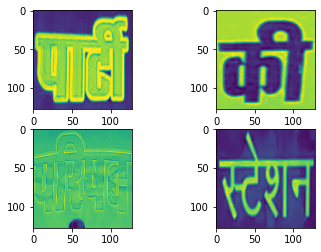

In [94]:
for ind,data in enumerate(dataloader1):
  if ind>0:break
  fig = plt.figure()
  nrows,ncols = batch_size//2,batch_size//2
  ax = fig.subplots(nrows,ncols)
  counter = 0
  for i in range(nrows):
    for j in range(ncols):
      ax[i,j].imshow(data['image'][counter][0])
      counter+=1



# ENCODER PART

In [95]:
class FeatureExtractor(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(3,64,3), ## (N,3,128,128) -> (N,64,124,124)
        nn.ReLU(),
        nn.AvgPool2d(2,2), ## (N,64,62,62)
        nn.Conv2d(64,256,3), ## (N,64,62,62) -> (N,256,60,60)
        nn.ReLU(),
        nn.AvgPool2d(2,2), ## (N,256,30,30)
        nn.Conv2d(256,512,5)
    )

  def forward(self,x):
    ff_pass = self.encoder(x)
    return ff_pass

# DECODER PART

In [110]:
## Extracted feature from CNN will act as input for Encoder-Decoder Model , each column x channel Depth on an input for the encoder-decoder model ## 
class LSTM_Net(nn.Module):
  def __init__(self,input_size=None,batch_size=None,hidden_size=None,output_size=None,numLayers=1,numDirns=1):
    self.hidden_size = hidden_size
    self.batch_size = batch_size
    self.numLayers = numLayers
    self.numDirns = numDirns

    super().__init__()
    self.hidden_size = hidden_size
    self.lstm_cell = nn.LSTM(input_size,hidden_size,batch_first=True)
    self.h2o = nn.Linear(hidden_size,output_size)
   

  def forward(self,input,hidden):
    out,hidden = self.lstm_cell(input,hidden)
    output = self.h2o(out)
    output = nn.functional.log_softmax(output,dim=2)
    return output
  
  def init_hiddenlayer(self,device='cpu'):
    return (torch.zeros(self.numLayers*self.numDirns,self.batch_size,self.hidden_size).to(device),torch.zeros(self.numLayers*self.numDirns,self.batch_size,self.hidden_size).to(device))


# Inference & Accuracy

In [111]:
def _computeAccuracy(source,target):
  def _convertTarget_toList(target):
    for e_array in np.asarray(target.tolist()) :
      newList = np.delete(e_array,np.where(e_array==0)).tolist()
      yield newList

  def _convertSource_toList(source):
    source = source.detach()
    source_idx = torch.argmax(source,dim=1)
    finalList = []

    for eList in source_idx:
      idx = torch.where(eList==0)[0]
      if len(idx)==0:continue
      eList,idx = eList.int().tolist(),idx.int().tolist()
      collapsedList = []
      temp = 0
      for i in idx:
        if i ==idx[-1]:ss = list(OrderedDict.fromkeys(eList[temp:]))
        else:
          ss = list(OrderedDict.fromkeys(eList[temp:i]))
        ss = [eVal for eVal in ss if eVal !=0]
        if len(ss)!=0:
          collapsedList.extend(ss)
        temp = i
      finalList.append(collapsedList)
    yield finalList

  
  targetList = list(_convertTarget_toList(target))
  sourceList = list(_convertSource_toList(source))[0]
  score =0
  partialScore = 0
  for eSource,eTarget in zip(sourceList,targetList):
    if set(eSource).issubset(eTarget) and len(eSource)==len(eTarget):score+=1
    elif set(eSource).issubset(eTarget):partialScore+=1
  
  return partialScore/source.size()[0],score/source.size()[0]
  
  

# BatchTraining 

In [112]:
def batchTrain(TextDataSet,EncoderModel=None,DecoderModel = None,lossFn=None,optimFn=None,batchSize=None,epochs=1,device='cpu'):
  loadedData = DataLoader(TextDataset,batch_size=batchSize,shuffle=True)
  maxLoss = 100000
  ## Intialize both the models ##
  for i in range(epochs):
    cummLoss = 0
    for ind,data in enumerate(loadedData):
      if data['image'].size()[0]!=batchSize:continue
      optimFn.zero_grad()
      img_tensor = data['image'].to(device)
      targets = data['label'].squeeze(2).to(device)
      encoder_fpass = EncoderModel(img_tensor).permute(0,3,1,2)
      encoder_fpass_new = encoder_fpass.view(encoder_fpass.shape[0],encoder_fpass.shape[1],-1)
      hidden = DecoderObj.init_hiddenlayer(device)
      decoder_fpass = DecoderObj(encoder_fpass_new,hidden).to(device)
      input_lengths = torch.full(size=(decoder_fpass.size()[0],), fill_value=decoder_fpass.size()[1], dtype=torch.long).to(device)
      target_lengths = torch.randint(low=1, high=targets.size()[1], size=(decoder_fpass.size()[0],), dtype=torch.long).to(device)
      loss =  lossFn(decoder_fpass.permute(1,0,2),targets,input_lengths,target_lengths)
      loss.backward()
      optimFn.step()
      cummLoss+=loss.item()*batchSize
     
    
    loss_per_epoch = cummLoss/batchSize
    if loss_per_epoch<maxLoss:
      maxLoss = loss_per_epoch
      torch.save({
          'epoch': i,
          'encoder_state_dict': EncoderModel.state_dict(),
          'decoder_state_dict': DecoderModel.state_dict(),
          'optimizer_state_dict': optimFn.state_dict(),
          'loss': loss_per_epoch,
          }, "model_Text_Recognition.pt")
    print("Loss Per Epoch {} for epoch {} ".format(cummLoss/batchSize,i+1)) 
    partialScore,fullScore = _computeAccuracy(decoder_fpass,targets)
    print("Partial Score --> {} , Full Score --> {}".format (partialScore,fullScore))
    


In [113]:
## HYPERPARAMETERS
batchSize = 100
num_layers = 1
num_dirn = 1
hidden_size = 200
lr = 0.0005

In [114]:
ctc_loss = nn.CTCLoss()
EncoderObj = FeatureExtractor().to(MyDevice)
DecoderObj = LSTM_Net(input_size=512*26,batch_size=batchSize,hidden_size=hidden_size,output_size=len(all_hindi_alpha),numLayers=num_layers,numDirns=num_dirn).to(MyDevice)
optimFn = optim.Adam(list(EncoderObj.parameters())+list(DecoderObj.parameters()),lr=lr)

In [109]:
batchTrain(TextDataset,EncoderModel=EncoderObj,DecoderModel=DecoderObj,lossFn=ctc_loss,optimFn=optimFn,batchSize=batchSize,epochs=,device=MyDevice)

tensor([[[-5.0605, -4.6760, -4.8311,  ..., -4.8236, -4.7261, -4.6858]],

        [[-4.9534, -4.6972, -4.9109,  ..., -4.8884, -4.8670, -4.6819]],

        [[-4.9656, -4.8439, -4.9600,  ..., -4.8731, -4.8794, -4.6804]],

        ...,

        [[-4.9497, -4.8260, -5.1818,  ..., -4.9202, -4.8521, -4.5456]],

        [[-5.0774, -4.7283, -4.8481,  ..., -4.9241, -4.7888, -4.6382]],

        [[-5.0716, -4.7174, -4.8806,  ..., -4.8664, -4.8353, -4.6645]]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward>)


ZeroDivisionError: ignored

In [ ]:
checkpoint = torch.load('model_Text_Recognition.pt')
EncoderObj.load_state_dict(checkpoint['encoder_state_dict'])
DecoderObj.load_state_dict(checkpoint['decoder_state_dict'])
optimFn.load_state_dict(checkpoint['optimizer_state_dict'])